## Setup

In [123]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


# Code to visualize the execution graph in the jupyter notebook
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    

In [124]:
import tensorflow as tf

In [125]:
def plot_image(image,title=None):
    plt.figure()
    plt.imshow(image, cmap="gray", interpolation="nearest")
    if title is not None:
        plt.title(title)
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")
    
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={X:np.reshape(stimuli,[1,784],order='F')})
    plotNNFilter(units)

# visualize convolution activations
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

# visualize convolution kernels
def plotConvLayerWeights(conv_layer_name, sess):
    kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, conv_layer_name)[0]
    weights = sess.run(kernel)
    print(kernel.shape)
    
    n_filters = int(kernel.shape[3])
    n_base_layers = int(kernel.shape[2])
    plt.figure(figsize=(20,20))
    for j in range(n_base_layers):
        for i in range(n_filters):
            plt.subplot(n_base_layers, n_filters, j * n_filters + i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(weights[:,:,j,i].reshape(kernel.shape[0],kernel.shape[1]), cmap='gray', interpolation='nearest')
            plt.title(str(i+1))

## Load MNIST

In [126]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Select 1459 and 023678 from MNIST

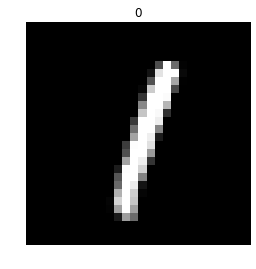

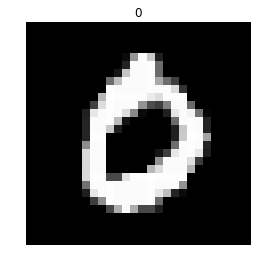

In [127]:
def prepare_data():
    global  dataset_1459_train, \
            dataset_023678_train, \
            X_1459_train, \
            y_1459_train, \
            X_1459_test, \
            y_1459_test, \
            X_023678_test, \
            y_023678_test, \
            X_023678_train, \
            y_023678_train
    mask_1459_train = np.logical_or.reduce([mnist.train.labels == v for v in [1,4,5,9]])
    mask_1459_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [1,4,5,9]])
    X_1459_train = np.compress(np.array(mask_1459_train), mnist.train.images, axis=0)
    _, y_1459_train = np.unique(mnist.train.labels[mask_1459_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_1459_train = tf.contrib.data.Dataset.from_tensor_slices((X_1459_train,y_1459_train))

    X_1459_test = np.compress(np.array(mask_1459_test), mnist.test.images, axis=0)
    _, y_1459_test = np.unique(mnist.test.labels[mask_1459_test], return_inverse=True)

    mask_023678_train = np.logical_or.reduce([mnist.train.labels == v for v in [0,2,3,6,7,8]])
    mask_023678_test  = np.logical_or.reduce([mnist.test.labels  == v for v in [0,2,3,6,7,8]])
    X_023678_train = np.compress(np.array(mask_023678_train), mnist.train.images, axis=0)
    _, y_023678_train = np.unique(mnist.train.labels[mask_023678_train], return_inverse=True) # 1,4,5,9 to 0,1,2,3
    dataset_023678_train = tf.contrib.data.Dataset.from_tensor_slices((X_023678_train,y_023678_train))

    X_023678_test = np.compress(np.array(mask_023678_test), mnist.test.images, axis=0)
    _, y_023678_test = np.unique(mnist.test.labels[mask_023678_test], return_inverse=True)

prepare_data()

# for example
plot_image(X_1459_test[2].reshape(28,28),title=y_1459_test[2])
plot_image(X_023678_test[2].reshape(28,28),title=y_023678_test[2])

# Convolutional Network

### Construct Graph

In [128]:
height = 28
width = 28
channels = 1
n_inputs = height * width
n_outputs = 4
keep_prob = 0.5

reset_graph()
prepare_data()

# Architecture inspiration : 
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/convolutional_network.py
# inputs layer
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

with tf.name_scope("conv"):
    # conv1 = tf.layers.conv2d(X_reshaped, ...)
    conv1 = tf.layers.conv2d(inputs=X_reshaped, filters=8, kernel_size=[5, 5], padding="same", activation=tf.nn.relu, name="conv1")
    # conv2 = tf.layers.conv2d(conv1, ...)
    # Applying dropout
    conv1_drop = tf.nn.dropout(conv1, keep_prob)
with tf.name_scope("pool2"):
    pool2 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=[1, 1], name="pool2")
    #pool2 = tf.layers.max_pooling2d(inputs=conv1_drop, pool_size=[2, 2], strides=[1, 1], name="pool2")

with tf.name_scope("conv"):
    conv2 = tf.layers.conv2d(inputs=pool2, filters=16, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, name="conv2")
    #conv2 = tf.layers.conv2d(inputs=conv1, filters=8, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, strides=[2,2], name="conv2")
    #conv2 = tf.layers.conv2d(inputs=conv1_drop, filters=8, kernel_size=[3, 3], padding="same", activation=tf.nn.relu, strides=[2,2], name="conv2")
    conv2_drop = tf.nn.dropout(conv2, keep_prob)

with tf.name_scope("pool3"):
    # pool3 = tf.nn.max_pool(conv2, ...)
    #pool3 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=[1, 1], name="pool3")
    pool3 = tf.layers.max_pooling2d(inputs=conv2_drop, pool_size=[2, 2], strides=[1, 1], name="pool3")
    # pool3_flat = tf.reshape(pool3, [-1])
    pool3_flat = tf.contrib.layers.flatten(pool3)
    #pool3_flat = tf.reshape(pool3, [-1,])
    print(tf.shape(pool3), tf.shape(pool3_flat))
    # print(pool3_flat)

with tf.name_scope("fc1"):
    # fc1 = tf.layers.dense(pool3_flat, ...)
    fc1 = tf.layers.dense(inputs=pool3_flat, units=24, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.nn.dropout(fc1, keep_prob)

with tf.name_scope("fc2"):
    # fc2 = tf.layers.dense(fc1, ...)
    #fc2 = tf.layers.dense(inputs=fc1, units=16, activation=tf.nn.relu, name="fc2")
    fc2 = tf.layers.dense(inputs=fc1_drop, units=16, activation=tf.nn.relu, name="fc2")

with tf.name_scope("output"):
    # logits = tf.layers.dense(fc2, ...)
    logits = tf.layers.dense(inputs=fc2, units=n_outputs, activation=tf.sigmoid)
    # Y_proba = tf.nn.softmax(logits, ...)
    Y_proba = tf.nn.softmax(logits)

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Tensor("pool3/Shape:0", shape=(4,), dtype=int32) Tensor("pool3/Shape_1:0", shape=(2,), dtype=int32)


### Train 1459

Training...
0 Train accuracy: 0.890363 Test accuracy: 0.887755
1 Train accuracy: 0.898299 Test accuracy: 0.897461
2 Train accuracy: 0.905413 Test accuracy: 0.911648
3 Train accuracy: 0.9014 Test accuracy: 0.909408
4 Train accuracy: 0.909335 Test accuracy: 0.914634
Finished training
Saving...
[(0, 0.82863933), (1, 0.8134709), (2, 0.80735487), (3, 0.81180865), (4, 0.79867268)]


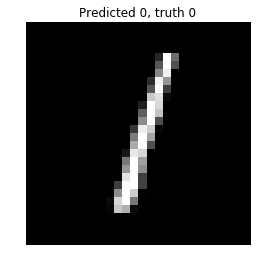

In [129]:
n_epochs = 5
batch_size = 10

print("Training...")
with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_1459_train.batch(batch_size)

    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    test_loss = []
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            try:
                X_batch, y_batch = sess.run(next_batch)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_1459_train, y: y_1459_train})
        acc_test = accuracy.eval(feed_dict={X: X_1459_test, y: y_1459_test})
        current_loss = sess.run(loss, feed_dict={X: X_1459_test, y: y_1459_test})
        test_loss.append((epoch, current_loss))
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    print("Finished training")

    print("Saving...")
    save_path = saver.save(sess, "./my_model_1459.ckpt")
    print(test_loss)
    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_1459_test[0]]})
    plot_image(X_1459_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_1459_test[0]))

### Build the graph for 023678

In [130]:
reset_graph()
prepare_data()
# Addition
n_outputs2 = 6
# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

# reuse the inputs (X,y)
X = tf.get_default_graph().get_tensor_by_name("inputs/X:0")
y = tf.get_default_graph().get_tensor_by_name("inputs/y:0")
# reuse the FC1 layer
fc1 = tf.get_default_graph().get_tensor_by_name("fc1/fc1/Relu:0")
# reuse the FC2 layer
fc2_reuse = tf.get_default_graph().get_tensor_by_name("fc2/fc2/Relu:0")

#keep_prob = 0.5
#fc1_drop = tf.nn.dropout(fc1, keep_prob)
# continue the 023678 graph from FC2...
with tf.name_scope("fc2_023678"):
    # fc2 = tf.layers.dense(fc1, ..., name="fc2_023678")
    fc2 = tf.layers.dense(inputs=fc1, units=16, activation=tf.nn.relu, name="fc2_023678")
    #fc2 = tf.layers.dense(inputs=fc1_drop, units=10, activation=tf.nn.relu, name="fc2_023678")
    #fc3 = tf.layers.dense(inputs=fc2, units=10, activation=tf.nn.relu, name="fc3_023678")

with tf.name_scope("softmax_023678"):
    # logits = tf.layers.dense(fc2, ..., name="output_023678")
    logits = tf.layers.dense(inputs=fc2, units=n_outputs2, activation=tf.sigmoid)
    #logits = tf.layers.dense(inputs=fc3, units=n_outputs2, activation=tf.sigmoid)
    # Y_proba = tf.nn.softmax(logits, name="Y_proba_023678")
    Y_proba = tf.nn.softmax(logits, name="Y_proba_023678")

with tf.name_scope("train_023678"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer(name="adam_023678")
## try to freeze everything but fc2, softmax
    #train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="fc2_023678|softmax_023678")
    #training_op = optimizer.minimize(loss, var_list=train_vars)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval_023678"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_023678"):
    init = tf.global_variables_initializer()
    new_saver = tf.train.Saver()

## Train transferred 023678

Training 023678...
INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
0 Train accuracy: 0.415928 Test accuracy: 0.433634
1 Train accuracy: 0.607988 Test accuracy: 0.619024
2 Train accuracy: 0.619508 Test accuracy: 0.63106
3 Train accuracy: 0.621232 Test accuracy: 0.630224
4 Train accuracy: 0.627249 Test accuracy: 0.635908
5 Train accuracy: 0.632329 Test accuracy: 0.639753
6 Train accuracy: 0.633417 Test accuracy: 0.643263
7 Train accuracy: 0.63254 Test accuracy: 0.640254
8 Train accuracy: 0.635473 Test accuracy: 0.64343
9 Train accuracy: 0.639222 Test accuracy: 0.646105
Finished training
[(0, 1.4543741), (1, 1.3529562), (2, 1.3376914), (3, 1.3315791), (4, 1.3282921), (5, 1.3257077), (6, 1.323977), (7, 1.3231087), (8, 1.322353), (9, 1.3214768)]


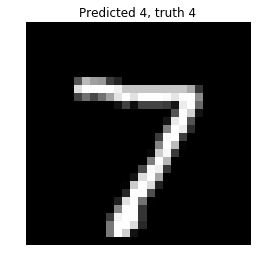

In [122]:
n_epochs = 10
batch_size = 10

print("Training 023678...")
#config = tf.ConfigProto()
#config.gpu_options.allocator_type = 'BFC'

with tf.Session() as sess:
    init.run()
    batched_dataset = dataset_023678_train.batch(batch_size)

    iterator = batched_dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    saver.restore(sess, "./my_model_1459.ckpt")
    test_loss = []
    for epoch in range(n_epochs):
        sess.run(iterator.initializer)
        while True:
            #print("Doing training")
            try:
                #print("Line 1:")
                X_batch, y_batch = sess.run(next_batch)
                #print("Line 2:")
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            except tf.errors.OutOfRangeError:
                # finished running through dataset
                break

        acc_train = accuracy.eval(feed_dict={X: X_023678_train, y: y_023678_train})
        acc_test = accuracy.eval(feed_dict={X: X_023678_test, y: y_023678_test})
        current_loss = sess.run(loss, feed_dict={X: X_023678_test, y: y_023678_test})
        test_loss.append((epoch, current_loss))
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        
    print("Finished training")
    print(test_loss)
    # for example
    inferred = sess.run(Y_proba, feed_dict={X: [X_023678_test[0]]})
    plot_image(X_023678_test[0].reshape(28,28), "Predicted %d, truth %d"%(np.argmax(inferred), y_023678_test[0]))

## Visualize the Feature Maps
The following code is useful to look into the activations of convolutional and pooling layers

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
Tensor("conv/conv1/Relu:0", shape=(?, 28, 28, 8), dtype=float32) Tensor("conv_1/conv2/Relu:0", shape=(?, 27, 27, 16), dtype=float32) Tensor("pool3/pool3/MaxPool:0", shape=(?, 26, 26, 16), dtype=float32)


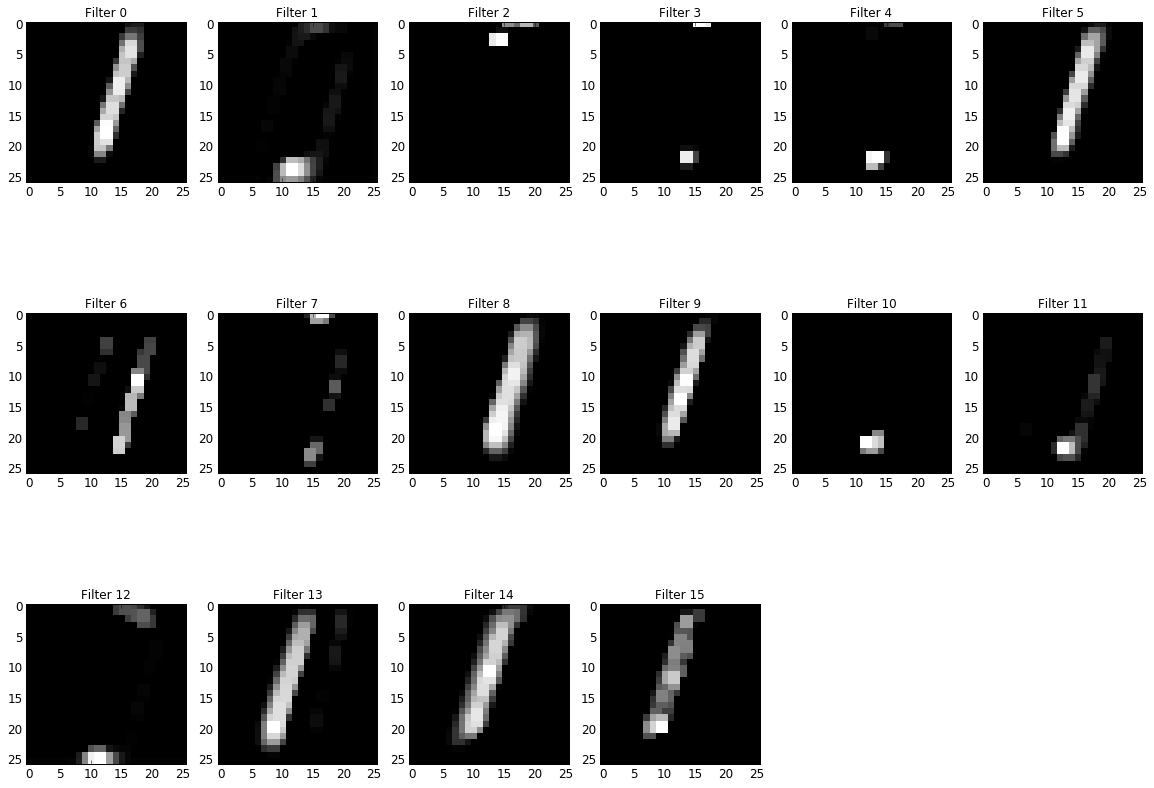

In [110]:
import math

with tf.Session() as sess:
    
    saver.restore(sess, "./my_model_1459.ckpt")
    # getActivations(tf.get_default_graph().get_tensor_by_name(...), X_1459_test[0])
    print(conv1, conv2, pool3)
    #getActivations(tf.get_default_graph().get_tensor_by_name("conv/conv1/Relu:0"), X_1459_test[0])
    #getActivations(tf.get_default_graph().get_tensor_by_name("conv_1/conv2/Relu:0"), X_1459_test[0])
    getActivations(tf.get_default_graph().get_tensor_by_name("pool3/pool3/MaxPool:0"), X_1459_test[0])

### Visualize the convolution kernels

INFO:tensorflow:Restoring parameters from ./my_model_1459.ckpt
(5, 5, 1, 8)
(3, 3, 8, 16)


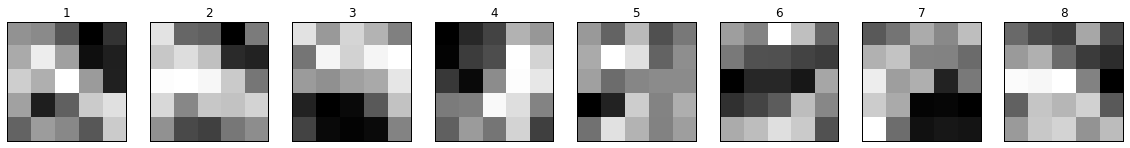

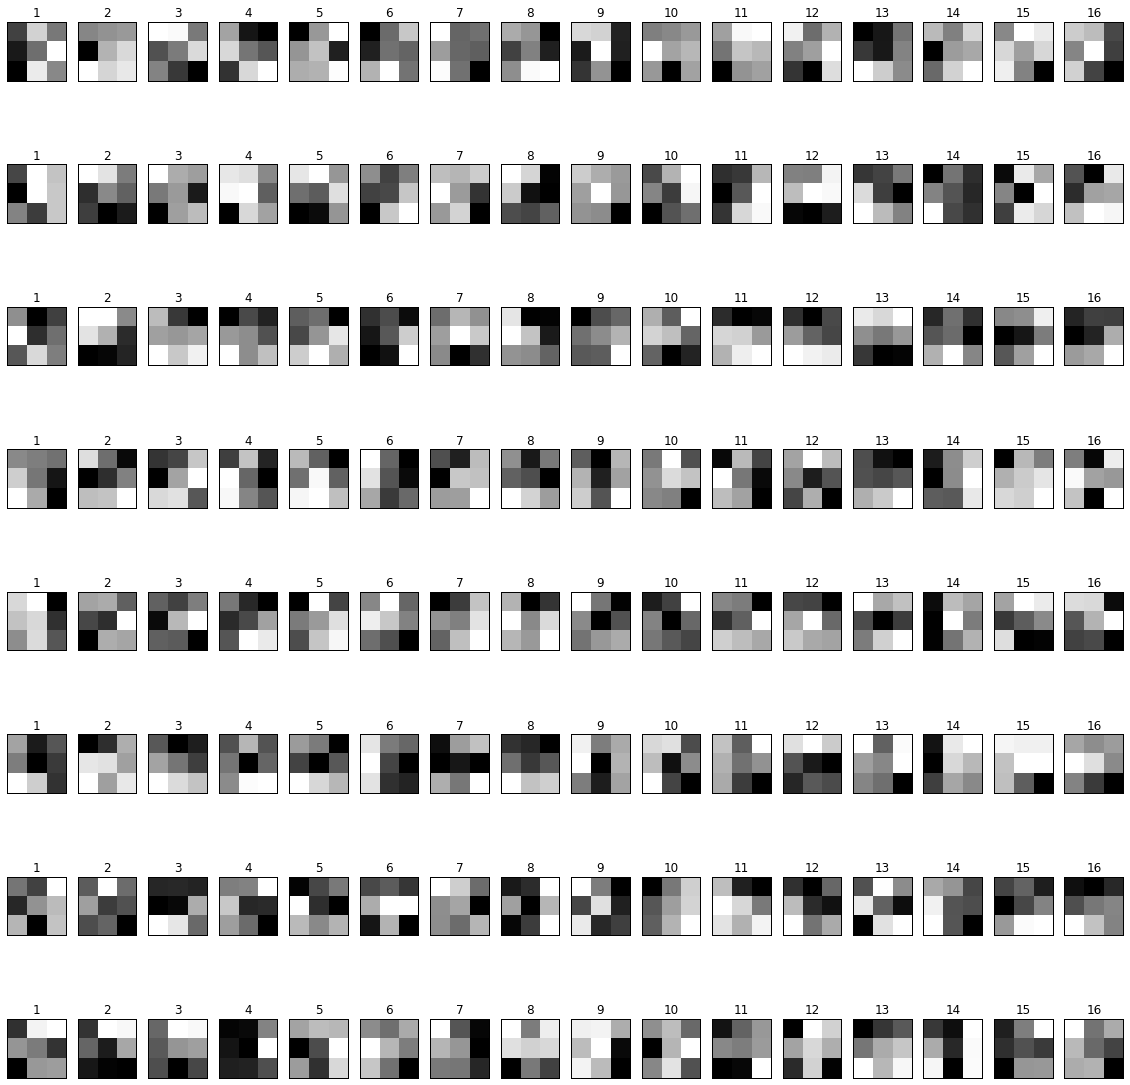

In [112]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_1459.ckpt")
    
    # plotConvLayerWeights(...)
    plotConvLayerWeights("conv1", sess)
    plotConvLayerWeights("conv2", sess)

## Show the Execution Graph

In [113]:
reset_graph()

# restore the graph of 1459
restore_saver = tf.train.import_meta_graph("./my_model_1459.ckpt.meta")

show_graph(tf.get_default_graph())